In [2]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import tiktoken

In [18]:
GPT_CONFIG_124M = {
    "vocab_size": 50257,    # Vocabulary size
    "n_layers": 12,         # Number of layers
    "n_heads": 12,          # Number of attention heads
    "emb_dim": 768,         # Embedding dimension
    "context_len": 1024,    # Context length
    "dropout": 0.1,         # Dropout rate
    "qkv_bias": False,      # Query-Key-Value bias
}

In [19]:
class DummyGPTModel(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.tok_emb = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"])
        self.pos_emb = nn.Embedding(cfg["context_len"], cfg["emb_dim"])
        self.dropout = nn.Dropout(cfg["dropout"])
        self.trf_blocks = nn.Sequential(*[DummyTransformerBlock(cfg) for _ in range(cfg["n_layers"])])
        self.ln_f = DummyLayerNorm(cfg["emb_dim"])
        self.out = nn.Linear(cfg["emb_dim"], cfg["vocab_size"])
        
    def forward(self, x):
        tok_emb = self.tok_emb(x)
        pos_emb = self.pos_emb(torch.arange(x.shape[1], device=x.device))
        x = self.dropout(tok_emb + pos_emb)
        x = self.trf_blocks(x)
        x = self.ln_f(x)
        return self.out(x)

class DummyLayerNorm(nn.Module):
    def __init__(self, emb_dim):
        super().__init__()
        
    def forward(self, x):
        return x

class DummyTransformerBlock(nn.Module):
    def __init__(self, cfg):
        super().__init__()
    
    def forward(self, x):
        return x

In [20]:
tokenizer = tiktoken.get_encoding("gpt2")
batch = []
txt1 = "Every effort moves you"
txt2 = "Every day holds a"
batch.append(torch.tensor(tokenizer.encode(txt1)))
batch.append(torch.tensor(tokenizer.encode(txt2)))
batch = torch.stack(batch)
print(f"Input batch shape (batch_size, seq_len): {batch.shape}")
print(f"Input token ids:\n{batch}")

model = DummyGPTModel(GPT_CONFIG_124M)
out = model(batch)
print(f"\nModel output shape (batch_size, seq_len, vocab_size): {out.shape}")
print(f"Model logits output (showing first 5 positions of first sequence):\n{out[0, :5, :5]}")

Input batch shape (batch_size, seq_len): torch.Size([2, 4])
Input token ids:
tensor([[6109, 3626, 6100,  345],
        [6109, 1110, 6622,  257]])

Model output shape (batch_size, seq_len, vocab_size): torch.Size([2, 4, 50257])
Model logits output (showing first 5 positions of first sequence):
tensor([[ 0.3722, -0.8748, -0.7952, -0.6558, -0.5530],
        [-1.0127, -1.2384,  0.2082,  0.0093, -1.0466],
        [-1.3580, -0.7232, -0.7673, -0.9863,  0.4627],
        [-0.9245, -1.0741, -0.1933, -0.0350, -0.4955]],
       grad_fn=<SliceBackward0>)


In [21]:
import torch
import torch.nn as nn
import numpy as np

# Create some toy data
# Imagine each row is a sample, and each column is a feature
data = torch.tensor([
    [1.0, 2.0, 3.0],    # Sample 1
    [4.0, 5.0, 6.0],    # Sample 2
    [7.0, 8.0, 9.0],    # Sample 3
], dtype=torch.float32)

print("Original Data:")
print(data)
print("\nShape:", data.shape)  # [3, 3] - (batch_size, features)

# Manual Layer Normalization (for demonstration)
def manual_layer_norm(x, eps=1e-5):
    # Normalize each sample (row) independently
    mean = x.mean(dim=-1, keepdim=True)
    var = x.var(dim=-1, keepdim=True, unbiased=False)
    return (x - mean) / torch.sqrt(var + eps)

# Manual Batch Normalization (for demonstration)
def manual_batch_norm(x, eps=1e-5):
    # Normalize each feature (column) across all samples
    mean = x.mean(dim=0, keepdim=True)
    var = x.var(dim=0, keepdim=True, unbiased=False)
    return (x - mean) / torch.sqrt(var + eps)

# Apply normalizations
layer_normalized = manual_layer_norm(data)
batch_normalized = manual_batch_norm(data)

print("\nLayer Normalized (normalized across features for each sample):")
print(layer_normalized)
print("\nMean of each sample:", layer_normalized.mean(dim=-1))
print("Std of each sample:", layer_normalized.std(dim=-1))

print("\nBatch Normalized (normalized across samples for each feature):")
print(batch_normalized)
print("\nMean of each feature:", batch_normalized.mean(dim=0))
print("Std of each feature:", batch_normalized.std(dim=0))

# Using PyTorch's built-in modules
ln = nn.LayerNorm(3)
bn = nn.BatchNorm1d(3)

# Need to add batch dimension for BatchNorm1d
pytorch_ln = ln(data)
pytorch_bn = bn(data.unsqueeze(0)).squeeze(0)

print("\nPyTorch LayerNorm (with learnable parameters):")
print(pytorch_ln)

print("\nPyTorch BatchNorm (with learnable parameters):")
print(pytorch_bn)

Original Data:
tensor([[1., 2., 3.],
        [4., 5., 6.],
        [7., 8., 9.]])

Shape: torch.Size([3, 3])

Layer Normalized (normalized across features for each sample):
tensor([[-1.2247,  0.0000,  1.2247],
        [-1.2247,  0.0000,  1.2247],
        [-1.2247,  0.0000,  1.2247]])

Mean of each sample: tensor([0., 0., 0.])
Std of each sample: tensor([1.2247, 1.2247, 1.2247])

Batch Normalized (normalized across samples for each feature):
tensor([[-1.2247, -1.2247, -1.2247],
        [ 0.0000,  0.0000,  0.0000],
        [ 1.2247,  1.2247,  1.2247]])

Mean of each feature: tensor([0., 0., 0.])
Std of each feature: tensor([1.2247, 1.2247, 1.2247])

PyTorch LayerNorm (with learnable parameters):
tensor([[-1.2247,  0.0000,  1.2247],
        [-1.2247,  0.0000,  1.2247],
        [-1.2247,  0.0000,  1.2247]], grad_fn=<NativeLayerNormBackward0>)

PyTorch BatchNorm (with learnable parameters):
tensor([[-1.2247,  0.0000,  1.2247],
        [-1.2247,  0.0000,  1.2247],
        [-1.2247,  0.0000, 

In [42]:
class LayerNorm(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.weight = nn.Parameter(torch.ones(cfg["emb_dim"]))
        self.bias = nn.Parameter(torch.zeros(cfg["emb_dim"]))
        self.eps = 1e-5
        
    def forward(self, x):
        mean = x.mean(dim=-1, keepdim=True)
        std = x.std(dim=-1, keepdim=True)
        normalized = (x - mean) / (std + self.eps)
        return normalized * self.weight + self.bias

In [43]:
class GELU(nn.Module):
    def __init__(self):
        super().__init__()
        
    def forward(self, x):
        return 0.5 * x * (1 + torch.tanh(torch.sqrt(torch.tensor(2.0/torch.pi)) * (x + 0.044715 * torch.pow(x, 3))))


In [44]:
class MLP(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(cfg["emb_dim"], 4 * cfg["emb_dim"]),
            GELU(),
            nn.Linear(4 * cfg["emb_dim"], cfg["emb_dim"]),
        )
        
    def forward(self, x):
        return self.layers(x)

In [27]:
ffn = MLP(GPT_CONFIG_124M)
x = torch.randn(2, 3, 768)
print(f"Input shape: {x.shape}")
print(f"Output shape: {ffn(x).shape}")

Input shape: torch.Size([2, 3, 768])
Output shape: torch.Size([2, 3, 768])


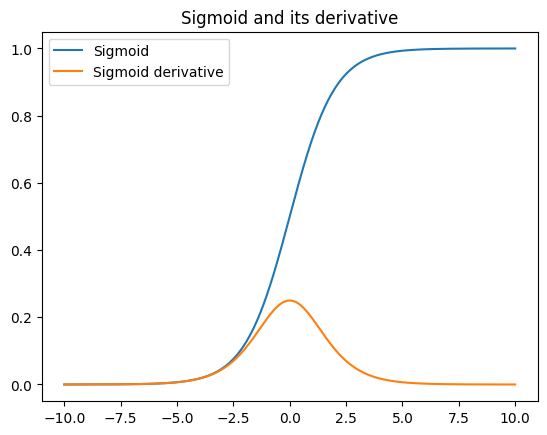

In [28]:
import torch
import matplotlib.pyplot as plt
import numpy as np

# Sigmoid function
def sigmoid(x):
    return 1 / (1 + torch.exp(-x))

# Sigmoid derivative
def sigmoid_derivative(x):
    s = sigmoid(x)
    return s * (1 - s)

# Plot sigmoid and its derivative
x = torch.linspace(-10, 10, 1000)
plt.plot(x, sigmoid(x), label='Sigmoid')
plt.plot(x, sigmoid_derivative(x), label='Sigmoid derivative')
plt.legend()
plt.title('Sigmoid and its derivative')
plt.show()

In [32]:
import torch
import torch.nn as nn

# Create a deep network with sigmoid activations
x = torch.randn(1, 10, requires_grad=True)
layers = []
weights = []  # Store weights to access their gradients

# Forward pass through 10 layers
current = x
for i in range(10):
    weight = torch.randn(10, 10, requires_grad=True)
    weights.append(weight)
    current = torch.sigmoid(current @ weight)
    layers.append(current)

# Backward pass
loss = current.sum()
loss.backward()

# Print gradients for weights instead of layer outputs
for i, weight in enumerate(weights):
    print(f"Layer {i+1} weight gradient magnitude: {weight.grad.abs().mean().item():.10f}")

Layer 1 weight gradient magnitude: 0.0000577073
Layer 2 weight gradient magnitude: 0.0000795246
Layer 3 weight gradient magnitude: 0.0001470869
Layer 4 weight gradient magnitude: 0.0002183794
Layer 5 weight gradient magnitude: 0.0005697141
Layer 6 weight gradient magnitude: 0.0009730658
Layer 7 weight gradient magnitude: 0.0026188565
Layer 8 weight gradient magnitude: 0.0132223777
Layer 9 weight gradient magnitude: 0.0380474105
Layer 10 weight gradient magnitude: 0.0588006005


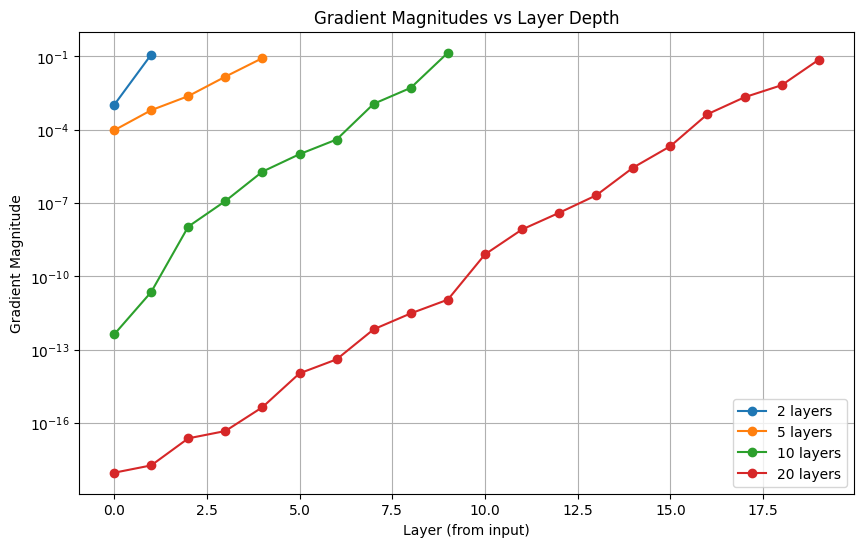

In [33]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

class DeepSigmoidNetwork(nn.Module):
    def __init__(self, num_layers):
        super().__init__()
        self.layers = nn.ModuleList([
            nn.Linear(1, 1) for _ in range(num_layers)
        ])
        
    def forward(self, x):
        for layer in self.layers:
            x = torch.sigmoid(layer(x))
        return x

# Create networks of different depths
depths = [2, 5, 10, 20]
gradients_per_depth = []

for depth in depths:
    # Create network and input
    model = DeepSigmoidNetwork(depth)
    x = torch.randn(1, 1, requires_grad=True)
    
    # Forward and backward pass
    output = model(x)
    loss = output.sum()
    loss.backward()
    
    # Collect gradients
    layer_grads = [layer.weight.grad.abs().item() for layer in model.layers]
    gradients_per_depth.append(layer_grads)

# Plot results
plt.figure(figsize=(10, 6))
for depth, grads in zip(depths, gradients_per_depth):
    plt.plot(range(depth), grads, marker='o', label=f'{depth} layers')
plt.xlabel('Layer (from input)')
plt.ylabel('Gradient Magnitude')
plt.title('Gradient Magnitudes vs Layer Depth')
plt.legend()
plt.yscale('log')  # Log scale to better show the vanishing
plt.grid(True)
plt.show()

In [35]:
class NetworkWithSkipConnections(nn.Module):
    def __init__(self, num_layers, use_skip=True):
        super().__init__()
        self.layers = nn.ModuleList([
            nn.Linear(10, 10) for _ in range(num_layers)
        ])
        self.use_skip = use_skip
        
    def forward(self, x):
        for layer in self.layers:
            if self.use_skip:
                identity = x
                x = torch.sigmoid(layer(x))
                x = x + identity  # Skip connection
            else:
                x = torch.sigmoid(layer(x))
        return x

# Compare gradients with and without skip connections
def get_gradients(use_skip):
    model = NetworkWithSkipConnections(10, use_skip=use_skip)
    x = torch.randn(1, 10, requires_grad=True)
    
    # Forward and backward pass
    out = model(x)
    loss = out.mean()
    loss.backward()
    
    # Collect gradients
    return [layer.weight.grad.abs().mean().item() for layer in model.layers]

# Get gradients for both cases
regular_grads = get_gradients(use_skip=False)
skip_grads = get_gradients(use_skip=True)

# Print comparison
for i, (reg, skip) in enumerate(zip(regular_grads, skip_grads)):
    print(f"Layer {i+1}:")
    print(f"  Without skip: {reg:.10f}")
    print(f"  With skip:    {skip:.10f}")

Layer 1:
  Without skip: 0.0000000001
  With skip:    0.0187536404
Layer 2:
  Without skip: 0.0000000010
  With skip:    0.0278111510
Layer 3:
  Without skip: 0.0000000057
  With skip:    0.0341989174
Layer 4:
  Without skip: 0.0000000536
  With skip:    0.0408292562
Layer 5:
  Without skip: 0.0000004554
  With skip:    0.0366820581
Layer 6:
  Without skip: 0.0000033839
  With skip:    0.0443569198
Layer 7:
  Without skip: 0.0000230342
  With skip:    0.0649564564
Layer 8:
  Without skip: 0.0001564800
  With skip:    0.0524591021
Layer 9:
  Without skip: 0.0014821721
  With skip:    0.0711952746
Layer 10:
  Without skip: 0.0117863389
  With skip:    0.0657608509


In [39]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_in, d_out, context_length, n_heads, dropout, qkv_bias):
        super().__init__()
        self.d_out = d_out
        self.n_heads = n_heads
        self.head_dim = d_out // n_heads
        self.q = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.k = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.v = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.dropout = nn.Dropout(dropout)
        self.out_proj = nn.Linear(d_out, d_out)
        self.register_buffer("mask", torch.triu(torch.ones(context_length, context_length), diagonal=1))
        
    def forward(self, x):
        B, T, C = x.shape
        Q = self.q(x).view(B, T, self.n_heads, self.head_dim).transpose(1, 2)
        K = self.k(x).view(B, T, self.n_heads, self.head_dim).transpose(1, 2)
        V = self.v(x).view(B, T, self.n_heads, self.head_dim).transpose(1, 2)
        attention_scores = Q @ K.transpose(-2, -1)
        mask = self.mask[:T, :T]
        attention_scores = attention_scores.masked_fill(mask.bool(), -torch.inf)
        attention_weights = torch.softmax(attention_scores / (self.head_dim ** 0.5), dim=-1)
        attention_weights = self.dropout(attention_weights)
        context_vectors = attention_weights @ V
        context_vectors = context_vectors.transpose(1, 2).contiguous().view(B, T, C)
        return self.out_proj(context_vectors)

In [40]:
class TransformerBlock(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.att = MultiHeadAttention(
            d_in=cfg["emb_dim"],
            d_out=cfg["emb_dim"],
            context_length=cfg["context_len"],
            n_heads=cfg["n_heads"],
            dropout=cfg["dropout"],
            qkv_bias=cfg["qkv_bias"]
        )
        self.ff = MLP(cfg)
        self.norm_1 = LayerNorm(cfg)
        self.norm_2 = LayerNorm(cfg)
        self.dropout = nn.Dropout(cfg["dropout"])
        
    def forward(self, x):
        short_cut = x
        x = self.norm_1(x)
        x = self.att(x)
        x = self.dropout(x)
        x = x + short_cut

        short_cut = x
        x = self.norm_2(x)
        x = self.ff(x)
        x = self.dropout(x)
        x = x + short_cut
        return x

In [46]:
batch = torch.randn(2, 10, 768)
block = TransformerBlock(GPT_CONFIG_124M)
out = block(batch)
print(f"Output shape: {out.shape}")

Output shape: torch.Size([2, 10, 768])


In [ ]:
import torch.nn.functional as F

x, y = next(dataloader)
out = model(x)
B, T, C = out.shape
out = out.view(B * T, C)
y = y.view(B * T)
loss = F.cross_entropy(out, y)
print(loss)
print(model.embedding_layer.token_embedding.weight.shape)
print(model.out_head.weight.shape)
# note could use weight tying to tye embeddding layer and output layer to save total weight nubmer
# Print parameters for each layer
emb_params = sum(p.numel() for p in model.embedding_layer.parameters())
block_params = sum(p.numel() for p in model.blocks.parameters()) 
ln_params = sum(p.numel() for p in model.ln_f.parameters())
out_params = sum(p.numel() for p in model.out_head.parameters())

print("Embedding layer:", emb_params)
print("Transformer blocks:", block_params)
print("Final layer norm:", ln_params) 
print("Output head:", out_params)

total_direct = sum(p.numel() for p in model.parameters())
total_summed = emb_params + block_params + ln_params + out_params

print("\nTotal parameters (direct):", total_direct)
print("Total parameters (summed):", total_summed)
assert total_direct == total_summed, "Parameter counts don't match!"

# Calculate memory usage in megabytes
# Each parameter is a float32 (4 bytes)
bytes_per_param = 4
total_bytes = total_direct * bytes_per_param
total_mb = total_bytes / (1024 * 1024)

print(f"\nModel size in memory: {total_mb:.2f} MB")
print(f"Model size in memory: {total_mb/1024:.2f} GB")


# GPT-2 Model Configurations
# Based on the original OpenAI GPT-2 model sizes

GPT_CONFIG_SMALL = {
    "vocab_size": 50257,    # Vocabulary size
    "n_layers": 12,         # Number of layers
    "n_heads": 12,          # Number of attention heads
    "emb_dim": 768,         # Embedding dimension
    "context_len": 1024,    # Context length
    "drop_rate": 0.1,       # Dropout rate 
    "qkv_bias": False,      # Query-Key-Value bias
    "batch_size": 2,        # Batch size
}

GPT_CONFIG_MEDIUM = {
    "vocab_size": 50257,
    "n_layers": 24,
    "n_heads": 16,
    "emb_dim": 1024,
    "context_len": 1024,
    "drop_rate": 0.1,
    "qkv_bias": False,
    "batch_size": 2,
}

GPT_CONFIG_LARGE = {
    "vocab_size": 50257,
    "n_layers": 36,
    "n_heads": 20,
    "emb_dim": 1280,
    "context_len": 1024,
    "drop_rate": 0.1,
    "qkv_bias": False,
    "batch_size": 2,
}

GPT_CONFIG_XL = {
    "vocab_size": 50257,
    "n_layers": 48,
    "n_heads": 25,
    "emb_dim": 1600, 
    "context_len": 1024,
    "drop_rate": 0.1,
    "qkv_bias": False,
    "batch_size": 2,
}
small_model = GPT2(GPT_CONFIG_SMALL)
medium_model = GPT2(GPT_CONFIG_MEDIUM)
large_model = GPT2(GPT_CONFIG_LARGE)
xl_model = GPT2(GPT_CONFIG_XL)
print(f"Number of parameters (small): {sum(p.numel() for p in small_model.parameters())}")
print(f"Number of parameters (medium): {sum(p.numel() for p in medium_model.parameters())}")
print(f"Number of parameters (large): {sum(p.numel() for p in large_model.parameters())}")
print(f"Number of parameters (xl): {sum(p.numel() for p in xl_model.parameters())}")
GPT_CONFIG_TEST = {
    "vocab_size": 50257,    # Vocabulary size
    "n_layers": 12,         # Number of layers
    "n_heads": 12,          # Number of attention heads
    "emb_dim": 768,         # Embedding dimension
    "context_len": 5,    # Context length
    "drop_rate": 0.1,       # Dropout rate 
    "qkv_bias": False,      # Query-Key-Value bias
    "batch_size": 2,        # Batch size
}

dataset = GPTDataset(raw_text, tokenizer, GPT_CONFIG_TEST["context_len"])
dataloader = iter(dataset.load_data(GPT_CONFIG_TEST["batch_size"]))
def generate_text_simple(model, idx, max_new_tokens, context_size):
    for _ in range(max_new_tokens):
        x = idx[:, -context_size:]
        with torch.no_grad():
            logits = model(x)
        logits = logits[:, -1, :]
        probs = F.softmax(logits, dim=-1)
        idx_next = torch.multinomial(probs, num_samples=1)
        idx = torch.cat((idx, idx_next), dim=1)
    return idx
x, y = next(dataloader)
for i in range(x.shape[0]):
    print(tokenizer.decode(x[i].tolist()))
small_model.eval()
idx_out = generate_text_simple(small_model, x, 5, GPT_CONFIG_TEST["context_len"])
for i in range(idx_out.shape[0]):
    decoded_out = tokenizer.decode(idx_out[i].tolist())  # idx_out[i] gets sequence i from the batch
    print(decoded_out)